In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr 

import src.f as f

In [3]:
meta = pd.read_csv("./data/task2/meta_data.csv", index_col=0)
prices = f.read_prices(path="./data/task2/data/")

rf = pd.read_csv(
    "./data/rf.csv", 
    index_col="Date", 
    parse_dates=True
).loc[:, "Price"]
rf = (1 + rf) ** (1 / 365) - 1

# Задание

Собрать портфель из минимум 20 акций, имеющий метрики:
$$SR \ge 0.36, CAGR \ge 6.3\%$$

# EDA и подготовка

In [4]:
print(
    f"Дата начала: {prices.index.min()}\n"
    f"Дата окончания: {prices.index.max()}\n"
    f"Кол-во бумаг = {prices.shape[1]}\n"
    f"Кол-во пропусков = {prices.isna().sum().sum()}\n"
)

Дата начала: 1998-12-01 00:00:00
Дата окончания: 2020-06-01 00:00:00
Кол-во бумаг = 299
Кол-во пропусков = 0



In [5]:
set(meta.ticker) - set(prices.columns)

{'INGR'}

По одной из бумаг нет данных по ценам (архив перепроверил), но при выборке из 300 бумаг не велика потеря.

In [6]:
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=prices.notnull(),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

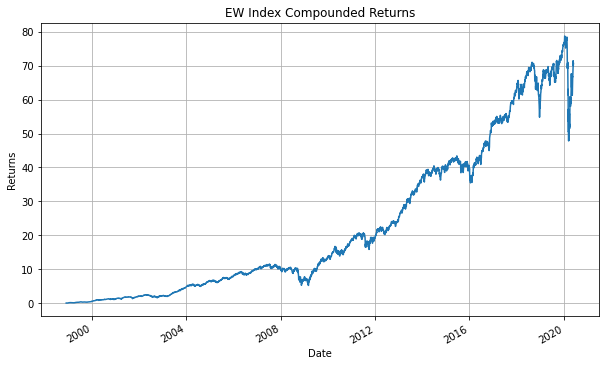

In [7]:
pqr.metrics.compounded_returns(benchmark).plot(
    figsize=(10, 6),
    title="EW Index Compounded Returns",
    xlabel="Date",
    ylabel="Returns",
    grid=True,
);

Равновзвешенный бенчмарк уже сам по себе имеет очень неплохие результаты и очевидно обгоняет S&P500. Есть ощущение, что это из-за того, что подвыборка акций сильно смещена - 300 компаний из почти 5000 на Американском рынке + из них половина с `Nasdaq`, т.е. небольшие технологические компании. При этом в выборке только те акции, которые торговались с 2000 по 2020 год - нет банкротов и делистингованных компаний, т.е. в данном бэктесте уже заложен lookahead bias. При реальном бэкстесте результаты наверняка были бы ощутимо хуже.

In [8]:
table = pqr.metrics.Table()
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=252,
        rf=rf / 252,
    ),
    name="Sharpe Ratio",
)
table.add_metric(
    metric=pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=252,
    ),
    multiplier=100,
    name="CAGR, %",
)

fig = pqr.metrics.Figure(
    metric=pqr.metrics.compounded_returns,
    name="Compounded Returns (log scale)",
    benchmark=benchmark,
    log_scale=True,
    kwargs={
        "figsize": (10, 6),
    },
)

summary = pqr.metrics.Dashboard([table, fig])

# Проверка факторов

## Momentum

Сначала протестируем старый-добрый моментум:
1. Ребалансируемся раз в год
2. Берем топ-20% (20%-40%, 40%-60% и т.д.) компаний с наибольшим моментумом за год + лаг в 1 месяц
3. Веса равные

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
Sharpe Ratio,0.69,0.88,0.86,1.01,1.43
"CAGR, %",14.15,16.21,15.40,19.80,37.56


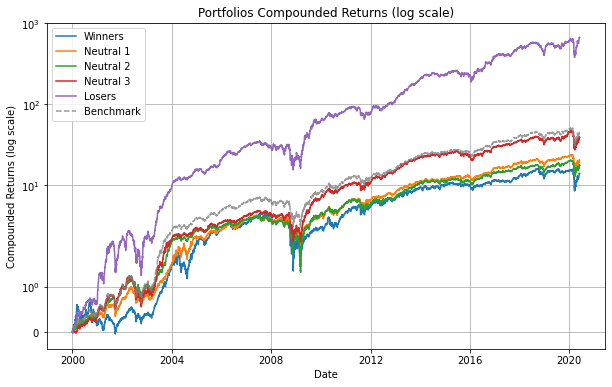

In [9]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=252),
    pqr.utils.partial(pqr.factors.lag, period=21),
    pqr.utils.partial(pqr.factors.hold, period=252),
)

mom = dynamic_transform(prices)

portfolios_mom = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_quantiles(5, better="more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_mom)

С первого подхода уже получилось выбить необходимые показатели, но это опять же особенность подвыборки данных. Правда, сработал не моментум, а реверсал - выгодно брать максимально упавшие акции в расчете на отскок.

## Size

Также протестируем фактор размера:
1. Ребалансируемся раз в год
2. Берем топ-20% (20%-40%, 40%-60% и т.д.) компаний с наименьшей капитализацией + лаг в 1 день
3. Веса равные

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
Sharpe Ratio,2.43,0.77,0.62,0.72,0.60
"CAGR, %",52.26,16.31,13.14,14.74,11.22


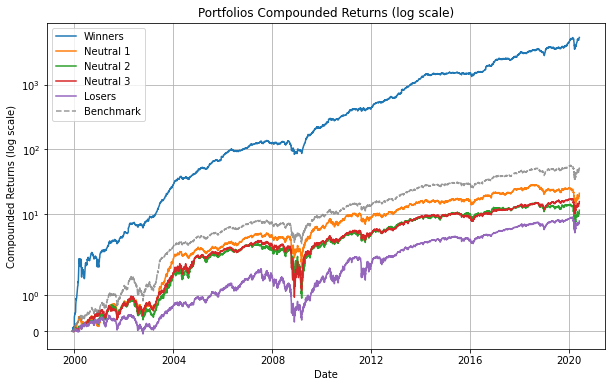

In [10]:
mcap = f.read_factor(
    factor="marketcap",
    path="./data/task2/fundamental_data.csv",
)

mcap, prices = mcap.align(prices, join="inner")

mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.look_back_mean, period=252),
    pqr.utils.partial(pqr.factors.lag, period=1),
    pqr.utils.partial(pqr.factors.hold, period=252),
)

size = mean_transform(mcap)

portfolios_size = pqr.factors.backtest_factor_portfolios(
    factor=size,
    strategies=pqr.factors.split_quantiles(5, better="less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_size)

Результаты получились неадекватно хорошие... Видимо, в выборке содержатся слишком маленькие компании, которые выстрелили на 1000 иксов, потому что иначе CAGR 52% объяснить сложно. Опять же возникают вопросы к выборке акций...

## Value

И фактор стоимости:
1. Ребалансируемся раз в год
2. Берем топ-20% (20%-40%, 40%-60% и т.д.) компаний с наименьшим `P/B` + лаг в 1 день
3. Веса равные

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
Sharpe Ratio,2.64,0.75,0.64,0.70,0.59
"CAGR, %",59.76,15.71,13.48,14.10,10.41


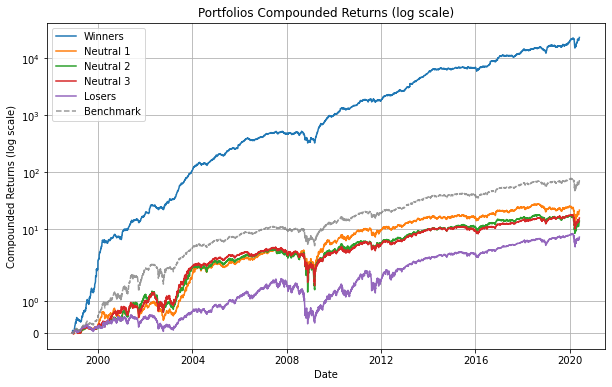

In [11]:
pb = f.read_factor(
    factor="pb",
    path="./data/task2/fundamental_data.csv",
)

pb, prices = mcap.align(prices, join="inner")

mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.look_back_mean, period=252),
    pqr.utils.partial(pqr.factors.lag, period=1),
    pqr.utils.partial(pqr.factors.hold, period=252),
)

value = mean_transform(pb)

portfolios_value = pqr.factors.backtest_factor_portfolios(
    factor=pb,
    strategies=pqr.factors.split_quantiles(5, better="less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_value)

Как ни странно, ситуация почти такая же - опять CAGR 52% и нереальный Шарп...

# Стратегия

Скомбинируем подходы `Size` и `Value` и будем отбирать в портфель только *дешевые маленькие* компании. 

,Size&Value
Sharpe Ratio,2.43
"CAGR, %",52.26


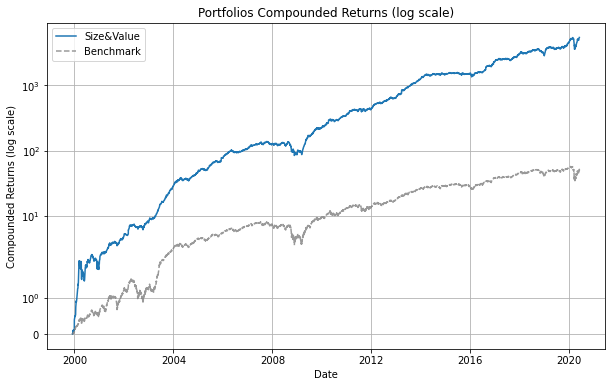

In [12]:
portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(size, 0, 0.2) & pqr.factors.quantiles(value, 0, 0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size&Value",
)

summary.display([portfolio])

Удалось незначительно увеличить Шарп и CAGR, но все равно выглядит это дело очень нереалистично.

# Проверка устойчивости

Думаю, что нет особого смысла останавливаться надолго - в академической литературе огромное кол-во исследований, посвященных анализу факторных стратегий и аномалий моментума/реверсала, размера и стоимости - их существование уже давно доказано и вряд ли может быть подвергнуто сомнению. 

В целом складывается ощущение, что для задания я должен был получить подвыборку с худшими акциями и попытаться достичь заявленных метрик, но где-то кто-то что-то перепутал, и я получил выборку с лучшими... :)

In [13]:
np.allclose(portfolio.holdings.sum(axis=1), 1)

True

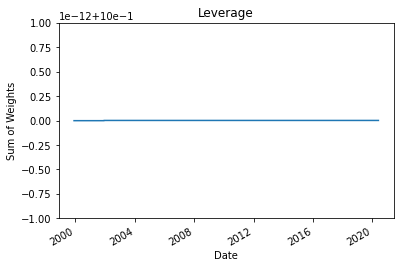

In [14]:
portfolio.holdings.sum(axis=1).plot(
    title="Leverage",
    xlabel="Date",
    ylabel="Sum of Weights"
);

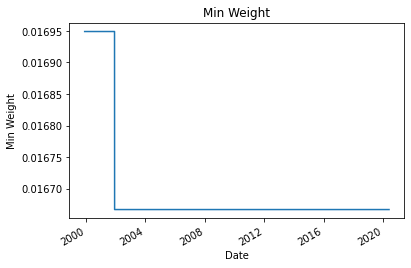

In [15]:
portfolio.holdings[portfolio.holdings != 0].min(axis=1).plot(
    title="Min Weight",
    xlabel="Date",
    ylabel="Min Weight",
);

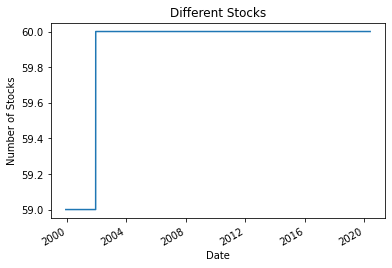

In [16]:
(portfolio.holdings > 0).sum(axis=1).plot(
    title="Different Stocks",
    xlabel="Date",
    ylabel="Number of Stocks",
);

In [17]:
(portfolio.holdings > 0).sum(axis=0).nlargest(10).rename("Most Popular Stocks")

ACY     5152
BASI    5152
BKSC    5152
CSPI    5152
ELSE    5152
ESMC    5152
ICCC    5152
IEHC    5152
NAII    5152
NOBH    5152
Name: Most Popular Stocks, dtype: int64

Использовался квантильный метод построения портфелей, поэтому все требования выполнены:

1. Акций в портфеле всегда чуть больше 60
2. Минимальный вес - 1.66%
3. Портфель загружен всегда на 100%

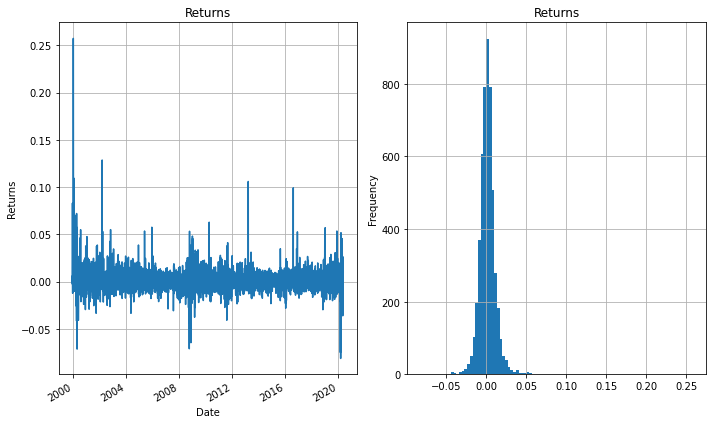

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

portfolio.returns.plot(
    ax=ax[0],
    title="Returns",
    xlabel="Date",
    ylabel="Returns",
    grid=True,
)

portfolio.returns.plot.hist(
    ax=ax[1],
    bins=100,
    title="Returns",
    xlabel="Date",
    ylabel="Returns",
    grid=True,
)

fig.tight_layout();

In [19]:
portfolio.returns.describe()

count    5152.000000
mean        0.001732
std         0.011328
min        -0.081171
25%        -0.003880
50%         0.001388
75%         0.006528
max         0.257196
dtype: float64

Доходность в целом несильно волатильна, но наблюдаются спайки вниз (2008 и 2020 годы) и вверх (2000 год) - следствие того, что в кризисы портфель загружен на 100%. Распределение доходности похоже на нормальное (возможно, лог-нормальное) со средним в нуле, но имеет тяжелый правый хваост, что говорит об эффективности стратегии.

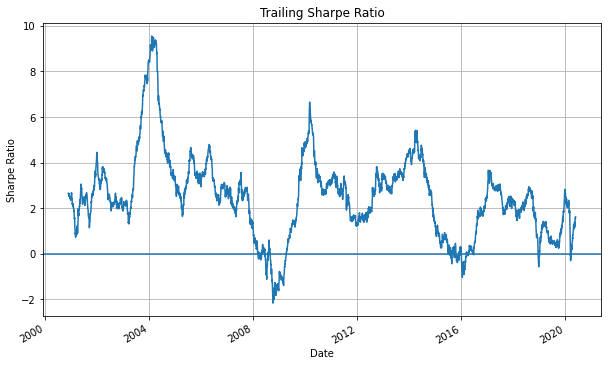

In [20]:
pqr.metrics.trailing_sharpe_ratio(
    portfolio,
    rf=rf,
    window=252,
    annualizer=252,
).plot(
    figsize=(10, 6),
    title="Trailing Sharpe Ratio",
    xlabel="Date",
    ylabel="Sharpe Ratio",
    grid=True,
)
plt.axhline(0);

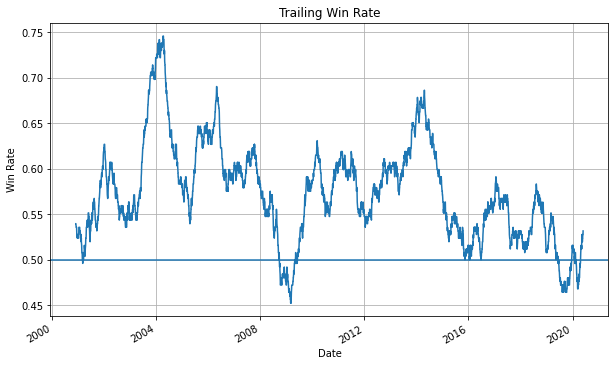

In [21]:
pqr.metrics.trailing_win_rate(
    portfolio,
    window=252,
).plot(
    figsize=(10, 6),
    title="Trailing Win Rate",
    xlabel="Date",
    ylabel="Win Rate",
    grid=True,
)
plt.axhline(0.5);

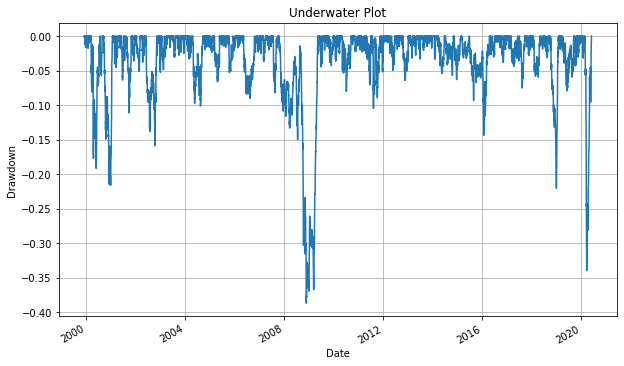

In [22]:
pqr.metrics.drawdown(
    portfolio,
).plot(
    figsize=(10, 6),
    title="Underwater Plot",
    xlabel="Date",
    ylabel="Drawdown",
    grid=True,
);

Метрики говорят сами за себя: Шарп почти всегда положительный (за исключением кризиса 2008 и 2020 годов), почти всегда больше 50% дней оказываются положительными, просадка в основном не превышает 20%, но в отдельные момент (выше упомянутые кризисы) доходила до 40%, что не очень хорошо.

В целом видно, что основной доход стратегия заработала в 2000-е годы, а затем наблюдается постепенное ухудшение эффективности стратегии. Тем не менее, она остается жизнеспособной, судя по метрикам, и позволяет продолжать обыгрывать рынок с ее помощью.